# HW 1 Part 2

## Visualize the optimization process

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
training_ds = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_ds = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())
import pandas

In [2]:
# Setting default device

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

display(f'{device} is available')

dtype = torch.float
torch.set_default_device(device)

'cuda is available'

In [3]:
class NMISTNetwork3(nn.Module):
        """Third CNN for NMIST"""
        def __init__(self):
            super().__init__()
            self.seq = nn.Sequential(
            nn.Conv2d(1, 32, 5), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 5),
            nn.Dropout(.25),
            nn.ReLU(),
            nn.Conv2d(64, 64, 5),
            nn.Flatten(1), 
            nn.Linear(16384, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            )
        
        def forward(self, x):
              output = self.seq(x)
              return output

In [4]:
def nmist_train_loop(dataloader, model, loss_fn, optimize, epoch):
    """Training loop funciton for non-linear function"""
    model.train()
    num_batches = len(dataloader)
    train_loss, correct = 0,0
    size = len(dataloader.dataset)
        
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        optimize.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()

        loss.backward()
        optimize.step()
    train_loss /= num_batches
    correct /=size
    
    grad_all = 0
    
    for params in model.parameters():
        grad = 0.0
        if params.grad is not None:
            grad = (params.grad.cpu().data.numpy() ** 2).sum()
        grad_all +=grad
    
    grad_norm = grad_all ** 0.5
    
    weights = torch.Tensor().to(device)
    last_layer_wht = torch.Tensor().to(device)
    for name, params in model.named_parameters():
        if 'weight' in name:
            #print(name, len(params), params.shape)
            weights = torch.concat((weights, torch.nn.utils.parameters_to_vector(params).to(device)))
            last_layer_wht = torch.nn.utils.parameters_to_vector(params).to(device)

    return train_loss, correct, grad_norm, weights, last_layer_wht
        
def nmist_val_loop(dataloader, model, loss_fn, epoch):
    """Eval loop function for non-linear function"""
    model.eval()
    size= len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /=size
    return test_loss, correct

In [5]:
# nmist3 = NMISTNetwork3()
# nmist3.load_state_dict(torch.load('nmist3_weights.pth', weights_only=True))
df = pandas.DataFrame(columns=['epoch', 'training_event', 'weights'])

In [6]:
df = pandas.DataFrame(columns=['epoch', 'loss', 'accuracy', 'grad_norm'])

epoch_tracker = dict()
last_weight = dict()

for training_event in range(8):
    nmist3 = NMISTNetwork3()
    
    loss_fn = torch.nn.CrossEntropyLoss()
    
    lr = 1.5e-2
    batch_size=150
    max_epochs = 25
    
    training_dl = DataLoader(training_ds, batch_size=batch_size)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    optimizer = torch.optim.SGD(nmist3.parameters(), lr=lr)

    
    for epoch in range(max_epochs):
        loss, accuracy, grad_norm, weights, last_layer_wht = nmist_train_loop(training_dl, nmist3, loss_fn, optimizer, epoch)
        if training_event ==0:
            row = pandas.DataFrame([[epoch, loss, accuracy, grad_norm]], columns=['epoch','loss','accuracy', 'grad_norm'])
            if df.empty:
                df = row
            else:
                df = pandas.concat([df, row], ignore_index=True)
        
        with torch.no_grad():
            if epoch%3==0:
                if epoch in epoch_tracker:
                    epoch_tracker[epoch] = torch.concat((epoch_tracker[epoch], weights.unsqueeze(-1).T))
                else:
                    epoch_tracker[epoch] = weights.unsqueeze(-1).T
                    
                if epoch in last_weight:
                    last_weight[epoch] = torch.concat((last_weight[epoch], last_layer_wht.unsqueeze(-1).T))
                else:
                    last_weight[epoch] = last_layer_wht.unsqueeze(-1).T
                
            display(f"Training event {training_event} Epoch {epoch}. Train loss: {loss}. Accuracy: {accuracy}. Grad_Norm: {grad_norm}.")
                                                   
        
    

'Training event 0 Epoch 0. Train loss: 0.6606803398299962. Accuracy: 0.8005. Grad_Norm: 8.116945266723633.'

'Training event 0 Epoch 1. Train loss: 0.20064436696469784. Accuracy: 0.9408166666666666. Grad_Norm: 8.138439178466797.'

'Training event 0 Epoch 2. Train loss: 0.14049775619292632. Accuracy: 0.9587666666666667. Grad_Norm: 6.685595989227295.'

'Training event 0 Epoch 3. Train loss: 0.11246666396502406. Accuracy: 0.9662666666666667. Grad_Norm: 7.577484607696533.'

'Training event 0 Epoch 4. Train loss: 0.09555954612907953. Accuracy: 0.9713833333333334. Grad_Norm: 6.299552917480469.'

'Training event 0 Epoch 5. Train loss: 0.08248254133737647. Accuracy: 0.9749333333333333. Grad_Norm: 6.741328239440918.'

'Training event 0 Epoch 6. Train loss: 0.07365947667858563. Accuracy: 0.9777. Grad_Norm: 5.257290840148926.'

'Training event 0 Epoch 7. Train loss: 0.06629935250326525. Accuracy: 0.97965. Grad_Norm: 5.578933238983154.'

'Training event 0 Epoch 8. Train loss: 0.06038928021444008. Accuracy: 0.9817. Grad_Norm: 4.890755653381348.'

'Training event 0 Epoch 9. Train loss: 0.055400999947451054. Accuracy: 0.9831333333333333. Grad_Norm: 4.740298271179199.'

'Training event 0 Epoch 10. Train loss: 0.050665656868659426. Accuracy: 0.9847166666666667. Grad_Norm: 5.09864616394043.'

'Training event 0 Epoch 11. Train loss: 0.04685133779188618. Accuracy: 0.9850333333333333. Grad_Norm: 5.370144367218018.'

'Training event 0 Epoch 12. Train loss: 0.04367406283068703. Accuracy: 0.9861833333333333. Grad_Norm: 6.452366352081299.'

'Training event 0 Epoch 13. Train loss: 0.04000857560546137. Accuracy: 0.9872333333333333. Grad_Norm: 5.863584041595459.'

'Training event 0 Epoch 14. Train loss: 0.03744627091931761. Accuracy: 0.9879. Grad_Norm: 6.373361110687256.'

'Training event 0 Epoch 15. Train loss: 0.034665393476170724. Accuracy: 0.9892666666666666. Grad_Norm: 6.226058483123779.'

'Training event 0 Epoch 16. Train loss: 0.03298848481077585. Accuracy: 0.98945. Grad_Norm: 5.919753551483154.'

'Training event 0 Epoch 17. Train loss: 0.03060020983844879. Accuracy: 0.9906333333333334. Grad_Norm: 7.481482982635498.'

'Training event 0 Epoch 18. Train loss: 0.028404889972443927. Accuracy: 0.9911166666666666. Grad_Norm: 5.463636875152588.'

'Training event 0 Epoch 19. Train loss: 0.027295733830833342. Accuracy: 0.9911. Grad_Norm: 10.147193908691406.'

'Training event 0 Epoch 20. Train loss: 0.024894501002127072. Accuracy: 0.9924333333333333. Grad_Norm: 7.873600006103516.'

'Training event 0 Epoch 21. Train loss: 0.02373176376146148. Accuracy: 0.9924833333333334. Grad_Norm: 6.586180210113525.'

'Training event 0 Epoch 22. Train loss: 0.02249490312384296. Accuracy: 0.9929666666666667. Grad_Norm: 9.043817520141602.'

'Training event 0 Epoch 23. Train loss: 0.021260648924508133. Accuracy: 0.9932333333333333. Grad_Norm: 7.304262161254883.'

'Training event 0 Epoch 24. Train loss: 0.01958945796235639. Accuracy: 0.9935333333333334. Grad_Norm: 8.663423538208008.'

'Training event 1 Epoch 0. Train loss: 0.6754742379765958. Accuracy: 0.7987. Grad_Norm: 4.9702467918396.'

'Training event 1 Epoch 1. Train loss: 0.20732254409696907. Accuracy: 0.9385833333333333. Grad_Norm: 4.825240612030029.'

'Training event 1 Epoch 2. Train loss: 0.14170374943176284. Accuracy: 0.9583666666666667. Grad_Norm: 5.019602298736572.'

'Training event 1 Epoch 3. Train loss: 0.11286529451142996. Accuracy: 0.9665666666666667. Grad_Norm: 4.929933547973633.'

'Training event 1 Epoch 4. Train loss: 0.09564282034814824. Accuracy: 0.9711. Grad_Norm: 4.570159912109375.'

'Training event 1 Epoch 5. Train loss: 0.08256438831798732. Accuracy: 0.97455. Grad_Norm: 6.057590007781982.'

'Training event 1 Epoch 6. Train loss: 0.07387284648430067. Accuracy: 0.97735. Grad_Norm: 6.779506683349609.'

'Training event 1 Epoch 7. Train loss: 0.06668393155385274. Accuracy: 0.9794833333333334. Grad_Norm: 5.0343828201293945.'

'Training event 1 Epoch 8. Train loss: 0.06048315247055143. Accuracy: 0.9812166666666666. Grad_Norm: 5.225710868835449.'

'Training event 1 Epoch 9. Train loss: 0.05555584897578228. Accuracy: 0.9824333333333334. Grad_Norm: 4.581118106842041.'

'Training event 1 Epoch 10. Train loss: 0.05107345644762972. Accuracy: 0.9839833333333333. Grad_Norm: 5.080938816070557.'

'Training event 1 Epoch 11. Train loss: 0.04716373589806608. Accuracy: 0.98535. Grad_Norm: 4.9564995765686035.'

'Training event 1 Epoch 12. Train loss: 0.043452527503104646. Accuracy: 0.9860833333333333. Grad_Norm: 5.6863508224487305.'

'Training event 1 Epoch 13. Train loss: 0.04064407733036205. Accuracy: 0.9873666666666666. Grad_Norm: 5.176784992218018.'

'Training event 1 Epoch 14. Train loss: 0.037561860636342315. Accuracy: 0.98835. Grad_Norm: 6.638326168060303.'

'Training event 1 Epoch 15. Train loss: 0.03492295204545371. Accuracy: 0.9892833333333333. Grad_Norm: 6.156366348266602.'

'Training event 1 Epoch 16. Train loss: 0.03334122810327244. Accuracy: 0.9895833333333334. Grad_Norm: 6.391071319580078.'

'Training event 1 Epoch 17. Train loss: 0.03087144881610584. Accuracy: 0.9901166666666666. Grad_Norm: 5.240536689758301.'

'Training event 1 Epoch 18. Train loss: 0.028761737017193808. Accuracy: 0.99135. Grad_Norm: 6.392405986785889.'

'Training event 1 Epoch 19. Train loss: 0.027519787017172347. Accuracy: 0.9915666666666667. Grad_Norm: 7.966658115386963.'

'Training event 1 Epoch 20. Train loss: 0.025984572472316357. Accuracy: 0.9918333333333333. Grad_Norm: 6.401013374328613.'

'Training event 1 Epoch 21. Train loss: 0.023447137353578. Accuracy: 0.9926666666666667. Grad_Norm: 7.437300205230713.'

'Training event 1 Epoch 22. Train loss: 0.022503221458737243. Accuracy: 0.99325. Grad_Norm: 7.6138916015625.'

'Training event 1 Epoch 23. Train loss: 0.021472261622084262. Accuracy: 0.9932666666666666. Grad_Norm: 7.062201023101807.'

'Training event 1 Epoch 24. Train loss: 0.020648903005421743. Accuracy: 0.9937. Grad_Norm: 7.46867561340332.'

'Training event 2 Epoch 0. Train loss: 0.8395345348306. Accuracy: 0.7447833333333334. Grad_Norm: 4.826344966888428.'

'Training event 2 Epoch 1. Train loss: 0.22230714070610702. Accuracy: 0.93385. Grad_Norm: 6.128306865692139.'

'Training event 2 Epoch 2. Train loss: 0.14911806650459766. Accuracy: 0.9559. Grad_Norm: 5.187249660491943.'

'Training event 2 Epoch 3. Train loss: 0.11625460009556264. Accuracy: 0.9658166666666667. Grad_Norm: 6.067966938018799.'

'Training event 2 Epoch 4. Train loss: 0.09755062753567473. Accuracy: 0.9707. Grad_Norm: 7.587416648864746.'

'Training event 2 Epoch 5. Train loss: 0.08494569740956649. Accuracy: 0.9748666666666667. Grad_Norm: 6.157808780670166.'

'Training event 2 Epoch 6. Train loss: 0.07464329947077203. Accuracy: 0.97745. Grad_Norm: 4.933650970458984.'

'Training event 2 Epoch 7. Train loss: 0.0667346934712259. Accuracy: 0.9801833333333333. Grad_Norm: 5.305863857269287.'

'Training event 2 Epoch 8. Train loss: 0.061082796229748056. Accuracy: 0.98165. Grad_Norm: 4.694754123687744.'

'Training event 2 Epoch 9. Train loss: 0.05589528179552872. Accuracy: 0.98285. Grad_Norm: 5.269112586975098.'

'Training event 2 Epoch 10. Train loss: 0.051331541772815396. Accuracy: 0.9844333333333334. Grad_Norm: 5.163111686706543.'

'Training event 2 Epoch 11. Train loss: 0.04790509881888284. Accuracy: 0.98495. Grad_Norm: 5.160558700561523.'

'Training event 2 Epoch 12. Train loss: 0.043786891219206155. Accuracy: 0.9865666666666667. Grad_Norm: 7.392287731170654.'

'Training event 2 Epoch 13. Train loss: 0.04018518354801927. Accuracy: 0.9875333333333334. Grad_Norm: 6.282036781311035.'

'Training event 2 Epoch 14. Train loss: 0.03809936695106444. Accuracy: 0.9882833333333333. Grad_Norm: 5.778608322143555.'

'Training event 2 Epoch 15. Train loss: 0.03633428619999904. Accuracy: 0.9885. Grad_Norm: 6.907647609710693.'

'Training event 2 Epoch 16. Train loss: 0.032613318169605915. Accuracy: 0.9903. Grad_Norm: 6.527371406555176.'

'Training event 2 Epoch 17. Train loss: 0.030882451629804564. Accuracy: 0.9905333333333334. Grad_Norm: 7.2654595375061035.'

'Training event 2 Epoch 18. Train loss: 0.029370449019334045. Accuracy: 0.99115. Grad_Norm: 7.955296993255615.'

'Training event 2 Epoch 19. Train loss: 0.02802953192658606. Accuracy: 0.9912333333333333. Grad_Norm: 6.885320663452148.'

'Training event 2 Epoch 20. Train loss: 0.026170976938446985. Accuracy: 0.99195. Grad_Norm: 11.312286376953125.'

'Training event 2 Epoch 21. Train loss: 0.02415805710676068. Accuracy: 0.9924833333333334. Grad_Norm: 8.023818016052246.'

'Training event 2 Epoch 22. Train loss: 0.02321555349828486. Accuracy: 0.9928. Grad_Norm: 7.909170627593994.'

'Training event 2 Epoch 23. Train loss: 0.02047486740957538. Accuracy: 0.9937. Grad_Norm: 8.363984107971191.'

'Training event 2 Epoch 24. Train loss: 0.020049761339323596. Accuracy: 0.9938166666666667. Grad_Norm: 9.725178718566895.'

'Training event 3 Epoch 0. Train loss: 0.7887153490632772. Accuracy: 0.7636. Grad_Norm: 5.985165119171143.'

'Training event 3 Epoch 1. Train loss: 0.2067200027871877. Accuracy: 0.9386333333333333. Grad_Norm: 5.1722917556762695.'

'Training event 3 Epoch 2. Train loss: 0.14172534683719276. Accuracy: 0.9576833333333333. Grad_Norm: 4.5234904289245605.'

'Training event 3 Epoch 3. Train loss: 0.11366987264482305. Accuracy: 0.9663833333333334. Grad_Norm: 4.974501609802246.'

'Training event 3 Epoch 4. Train loss: 0.09588431355834473. Accuracy: 0.97135. Grad_Norm: 4.587835788726807.'

'Training event 3 Epoch 5. Train loss: 0.08385327195661375. Accuracy: 0.9748333333333333. Grad_Norm: 5.146228790283203.'

'Training event 3 Epoch 6. Train loss: 0.07368541291740258. Accuracy: 0.9777166666666667. Grad_Norm: 4.63782262802124.'

'Training event 3 Epoch 7. Train loss: 0.0672104041534476. Accuracy: 0.9795833333333334. Grad_Norm: 6.365352153778076.'

'Training event 3 Epoch 8. Train loss: 0.06055574230471393. Accuracy: 0.9817166666666667. Grad_Norm: 5.9243035316467285.'

'Training event 3 Epoch 9. Train loss: 0.0561630515565048. Accuracy: 0.9829666666666667. Grad_Norm: 4.655190467834473.'

'Training event 3 Epoch 10. Train loss: 0.05187036991090281. Accuracy: 0.98425. Grad_Norm: 4.192098617553711.'

'Training event 3 Epoch 11. Train loss: 0.04797389961924637. Accuracy: 0.9853333333333333. Grad_Norm: 4.6152663230896.'

'Training event 3 Epoch 12. Train loss: 0.0449971697460569. Accuracy: 0.9862833333333333. Grad_Norm: 4.876312255859375.'

'Training event 3 Epoch 13. Train loss: 0.04122252194516477. Accuracy: 0.9874833333333334. Grad_Norm: 4.665658950805664.'

'Training event 3 Epoch 14. Train loss: 0.03905379480267584. Accuracy: 0.9884333333333334. Grad_Norm: 5.108037948608398.'

'Training event 3 Epoch 15. Train loss: 0.03670975872955751. Accuracy: 0.9885. Grad_Norm: 4.93857479095459.'

'Training event 3 Epoch 16. Train loss: 0.03484510401060106. Accuracy: 0.9892666666666666. Grad_Norm: 4.5956645011901855.'

'Training event 3 Epoch 17. Train loss: 0.03283004227247147. Accuracy: 0.98995. Grad_Norm: 5.006052017211914.'

'Training event 3 Epoch 18. Train loss: 0.030758730070920136. Accuracy: 0.9906. Grad_Norm: 4.594455242156982.'

'Training event 3 Epoch 19. Train loss: 0.029421594878585894. Accuracy: 0.9908166666666667. Grad_Norm: 5.688283443450928.'

'Training event 3 Epoch 20. Train loss: 0.02723319215721858. Accuracy: 0.9915166666666667. Grad_Norm: 5.670306205749512.'

'Training event 3 Epoch 21. Train loss: 0.026030755167648748. Accuracy: 0.9923166666666666. Grad_Norm: 5.751900672912598.'

'Training event 3 Epoch 22. Train loss: 0.024736991971658427. Accuracy: 0.9926333333333334. Grad_Norm: 6.0842604637146.'

'Training event 3 Epoch 23. Train loss: 0.02294429777750338. Accuracy: 0.9931. Grad_Norm: 5.4730305671691895.'

'Training event 3 Epoch 24. Train loss: 0.02231037965422729. Accuracy: 0.9933333333333333. Grad_Norm: 5.923467636108398.'

'Training event 4 Epoch 0. Train loss: 0.8232310787588358. Accuracy: 0.7497. Grad_Norm: 6.4258880615234375.'

'Training event 4 Epoch 1. Train loss: 0.21459788472857327. Accuracy: 0.9368833333333333. Grad_Norm: 6.724616050720215.'

'Training event 4 Epoch 2. Train loss: 0.14538049873313866. Accuracy: 0.9568166666666666. Grad_Norm: 6.920319557189941.'

'Training event 4 Epoch 3. Train loss: 0.11346429377561434. Accuracy: 0.9667166666666667. Grad_Norm: 4.587561130523682.'

'Training event 4 Epoch 4. Train loss: 0.09459636081068311. Accuracy: 0.9720833333333333. Grad_Norm: 3.9484658241271973.'

'Training event 4 Epoch 5. Train loss: 0.08207329559343635. Accuracy: 0.9756. Grad_Norm: 3.794018030166626.'

'Training event 4 Epoch 6. Train loss: 0.07227658523188438. Accuracy: 0.97795. Grad_Norm: 3.9323489665985107.'

'Training event 4 Epoch 7. Train loss: 0.06489616105216556. Accuracy: 0.9802. Grad_Norm: 3.3771770000457764.'

'Training event 4 Epoch 8. Train loss: 0.05952357704896713. Accuracy: 0.98195. Grad_Norm: 4.077938079833984.'

'Training event 4 Epoch 9. Train loss: 0.055021558322187046. Accuracy: 0.9830166666666666. Grad_Norm: 3.8914754390716553.'

'Training event 4 Epoch 10. Train loss: 0.05076185753685422. Accuracy: 0.9839833333333333. Grad_Norm: 4.3308563232421875.'

'Training event 4 Epoch 11. Train loss: 0.04662827015577932. Accuracy: 0.9856166666666667. Grad_Norm: 3.978306293487549.'

'Training event 4 Epoch 12. Train loss: 0.04382965309327119. Accuracy: 0.9862833333333333. Grad_Norm: 5.170163631439209.'

'Training event 4 Epoch 13. Train loss: 0.04044523480013595. Accuracy: 0.98775. Grad_Norm: 5.111854076385498.'

'Training event 4 Epoch 14. Train loss: 0.038010324984861656. Accuracy: 0.9882666666666666. Grad_Norm: 4.81057596206665.'

'Training event 4 Epoch 15. Train loss: 0.03491582591566839. Accuracy: 0.9892. Grad_Norm: 6.32996129989624.'

'Training event 4 Epoch 16. Train loss: 0.03363901321230514. Accuracy: 0.9897. Grad_Norm: 5.550711154937744.'

'Training event 4 Epoch 17. Train loss: 0.03152919906773605. Accuracy: 0.9903. Grad_Norm: 6.814720153808594.'

'Training event 4 Epoch 18. Train loss: 0.0296915116195305. Accuracy: 0.99085. Grad_Norm: 6.521158695220947.'

'Training event 4 Epoch 19. Train loss: 0.027539732821587677. Accuracy: 0.9915. Grad_Norm: 6.463327407836914.'

'Training event 4 Epoch 20. Train loss: 0.026424534983871126. Accuracy: 0.9917166666666667. Grad_Norm: 7.669370174407959.'

'Training event 4 Epoch 21. Train loss: 0.024824872477183818. Accuracy: 0.9923333333333333. Grad_Norm: 8.201427459716797.'

'Training event 4 Epoch 22. Train loss: 0.02386286966080661. Accuracy: 0.9923333333333333. Grad_Norm: 7.391864776611328.'

'Training event 4 Epoch 23. Train loss: 0.02228987176130431. Accuracy: 0.9932833333333333. Grad_Norm: 8.777159690856934.'

'Training event 4 Epoch 24. Train loss: 0.020597974514184898. Accuracy: 0.9936333333333334. Grad_Norm: 8.2366943359375.'

'Training event 5 Epoch 0. Train loss: 0.7255793299153447. Accuracy: 0.7900333333333334. Grad_Norm: 6.625109672546387.'

'Training event 5 Epoch 1. Train loss: 0.20984597850125283. Accuracy: 0.9373666666666667. Grad_Norm: 8.440110206604004.'

'Training event 5 Epoch 2. Train loss: 0.14269471071776935. Accuracy: 0.9576666666666667. Grad_Norm: 6.46063232421875.'

'Training event 5 Epoch 3. Train loss: 0.11197358934441581. Accuracy: 0.9663. Grad_Norm: 6.079866886138916.'

'Training event 5 Epoch 4. Train loss: 0.09424268111935817. Accuracy: 0.9718833333333333. Grad_Norm: 5.74579381942749.'

'Training event 5 Epoch 5. Train loss: 0.08137050272955093. Accuracy: 0.97525. Grad_Norm: 4.244518756866455.'

'Training event 5 Epoch 6. Train loss: 0.07205939207982738. Accuracy: 0.9779666666666667. Grad_Norm: 4.143833637237549.'

'Training event 5 Epoch 7. Train loss: 0.06459282834315673. Accuracy: 0.98025. Grad_Norm: 4.2390971183776855.'

'Training event 5 Epoch 8. Train loss: 0.05842883310426259. Accuracy: 0.9821. Grad_Norm: 4.364353656768799.'

'Training event 5 Epoch 9. Train loss: 0.05340672446254757. Accuracy: 0.9839666666666667. Grad_Norm: 4.452486991882324.'

'Training event 5 Epoch 10. Train loss: 0.04921651332319016. Accuracy: 0.98465. Grad_Norm: 7.82482385635376.'

'Training event 5 Epoch 11. Train loss: 0.04615385370663717. Accuracy: 0.9858833333333333. Grad_Norm: 5.58181619644165.'

'Training event 5 Epoch 12. Train loss: 0.04245220804514247. Accuracy: 0.9868166666666667. Grad_Norm: 5.3679399490356445.'

'Training event 5 Epoch 13. Train loss: 0.03966198562295176. Accuracy: 0.9878166666666667. Grad_Norm: 5.061953067779541.'

'Training event 5 Epoch 14. Train loss: 0.03615975462278584. Accuracy: 0.989. Grad_Norm: 5.5575971603393555.'

'Training event 5 Epoch 15. Train loss: 0.03354733478234266. Accuracy: 0.9897666666666667. Grad_Norm: 5.8144001960754395.'

'Training event 5 Epoch 16. Train loss: 0.03186268327961443. Accuracy: 0.9901833333333333. Grad_Norm: 5.383296012878418.'

'Training event 5 Epoch 17. Train loss: 0.030234439203486545. Accuracy: 0.9902166666666666. Grad_Norm: 7.2215895652771.'

'Training event 5 Epoch 18. Train loss: 0.028172500129439868. Accuracy: 0.9915333333333334. Grad_Norm: 7.948782920837402.'

'Training event 5 Epoch 19. Train loss: 0.02615662067080848. Accuracy: 0.9918666666666667. Grad_Norm: 7.252586364746094.'

'Training event 5 Epoch 20. Train loss: 0.024560125077405248. Accuracy: 0.9924166666666666. Grad_Norm: 10.191340446472168.'

'Training event 5 Epoch 21. Train loss: 0.0234832410535455. Accuracy: 0.9922833333333333. Grad_Norm: 7.571070671081543.'

'Training event 5 Epoch 22. Train loss: 0.022425485932762966. Accuracy: 0.9926333333333334. Grad_Norm: 5.992116928100586.'

'Training event 5 Epoch 23. Train loss: 0.02040488281840226. Accuracy: 0.9936333333333334. Grad_Norm: 6.93582820892334.'

'Training event 5 Epoch 24. Train loss: 0.01913787887133367. Accuracy: 0.9938833333333333. Grad_Norm: 12.302896499633789.'

'Training event 6 Epoch 0. Train loss: 0.7235119371674955. Accuracy: 0.7887833333333333. Grad_Norm: 3.3273653984069824.'

'Training event 6 Epoch 1. Train loss: 0.20681342381518333. Accuracy: 0.93795. Grad_Norm: 3.2055835723876953.'

'Training event 6 Epoch 2. Train loss: 0.14042972813826055. Accuracy: 0.958. Grad_Norm: 3.5342187881469727.'

'Training event 6 Epoch 3. Train loss: 0.11093698110897093. Accuracy: 0.9671. Grad_Norm: 4.085833549499512.'

'Training event 6 Epoch 4. Train loss: 0.0936148090811912. Accuracy: 0.9722. Grad_Norm: 4.643890857696533.'

'Training event 6 Epoch 5. Train loss: 0.08095627599279397. Accuracy: 0.9753666666666667. Grad_Norm: 4.990348815917969.'

'Training event 6 Epoch 6. Train loss: 0.0715294076394639. Accuracy: 0.9785833333333334. Grad_Norm: 5.054285526275635.'

'Training event 6 Epoch 7. Train loss: 0.06480713588680373. Accuracy: 0.98045. Grad_Norm: 6.33013391494751.'

'Training event 6 Epoch 8. Train loss: 0.05861907075275667. Accuracy: 0.9824666666666667. Grad_Norm: 6.026289939880371.'

'Training event 6 Epoch 9. Train loss: 0.05390603666601237. Accuracy: 0.9836. Grad_Norm: 6.285213470458984.'

'Training event 6 Epoch 10. Train loss: 0.05052077000626014. Accuracy: 0.9843666666666666. Grad_Norm: 6.445136547088623.'

'Training event 6 Epoch 11. Train loss: 0.046726275420951424. Accuracy: 0.9857166666666667. Grad_Norm: 8.217589378356934.'

'Training event 6 Epoch 12. Train loss: 0.04328713108057855. Accuracy: 0.9864. Grad_Norm: 9.441773414611816.'

'Training event 6 Epoch 13. Train loss: 0.04056153723198804. Accuracy: 0.9868833333333333. Grad_Norm: 6.431999683380127.'

'Training event 6 Epoch 14. Train loss: 0.03744931296474533. Accuracy: 0.9885666666666667. Grad_Norm: 5.840804100036621.'

'Training event 6 Epoch 15. Train loss: 0.03563471912988461. Accuracy: 0.9884666666666667. Grad_Norm: 6.496604919433594.'

'Training event 6 Epoch 16. Train loss: 0.033248126061080255. Accuracy: 0.9893333333333333. Grad_Norm: 6.788370609283447.'

'Training event 6 Epoch 17. Train loss: 0.030725568077978094. Accuracy: 0.9902833333333333. Grad_Norm: 5.860218524932861.'

'Training event 6 Epoch 18. Train loss: 0.028850678946837433. Accuracy: 0.9907833333333333. Grad_Norm: 6.9289960861206055.'

'Training event 6 Epoch 19. Train loss: 0.026003377543311217. Accuracy: 0.9919. Grad_Norm: 5.840104103088379.'

'Training event 6 Epoch 20. Train loss: 0.02539007442068396. Accuracy: 0.9920333333333333. Grad_Norm: 6.881415843963623.'

'Training event 6 Epoch 21. Train loss: 0.023038286782375506. Accuracy: 0.9930666666666667. Grad_Norm: 5.48060941696167.'

'Training event 6 Epoch 22. Train loss: 0.022563273634987127. Accuracy: 0.9927833333333334. Grad_Norm: 6.748294353485107.'

'Training event 6 Epoch 23. Train loss: 0.022043085090699605. Accuracy: 0.9927166666666667. Grad_Norm: 6.142216205596924.'

'Training event 6 Epoch 24. Train loss: 0.02033543843372172. Accuracy: 0.9935833333333334. Grad_Norm: 6.8083577156066895.'

'Training event 7 Epoch 0. Train loss: 0.7069044446945191. Accuracy: 0.7932. Grad_Norm: 6.1559953689575195.'

'Training event 7 Epoch 1. Train loss: 0.20727350222412497. Accuracy: 0.9381666666666667. Grad_Norm: 5.000757694244385.'

'Training event 7 Epoch 2. Train loss: 0.14362110933754593. Accuracy: 0.9577166666666667. Grad_Norm: 4.787680625915527.'

'Training event 7 Epoch 3. Train loss: 0.11133545937191229. Accuracy: 0.9671333333333333. Grad_Norm: 5.028122425079346.'

'Training event 7 Epoch 4. Train loss: 0.09207228677812963. Accuracy: 0.9727333333333333. Grad_Norm: 4.737630844116211.'

'Training event 7 Epoch 5. Train loss: 0.07958662464923691. Accuracy: 0.9762333333333333. Grad_Norm: 5.108012676239014.'

'Training event 7 Epoch 6. Train loss: 0.07109964106726693. Accuracy: 0.9792166666666666. Grad_Norm: 5.755459785461426.'

'Training event 7 Epoch 7. Train loss: 0.06340656958083855. Accuracy: 0.9811. Grad_Norm: 5.0336480140686035.'

'Training event 7 Epoch 8. Train loss: 0.05826358447520761. Accuracy: 0.9819833333333333. Grad_Norm: 6.1800150871276855.'

'Training event 7 Epoch 9. Train loss: 0.05292299817345338. Accuracy: 0.9840833333333333. Grad_Norm: 7.423544883728027.'

'Training event 7 Epoch 10. Train loss: 0.049026355023816. Accuracy: 0.9852. Grad_Norm: 6.220908164978027.'

'Training event 7 Epoch 11. Train loss: 0.045979599060810866. Accuracy: 0.9857666666666667. Grad_Norm: 8.994340896606445.'

'Training event 7 Epoch 12. Train loss: 0.04213771290407749. Accuracy: 0.9869. Grad_Norm: 7.108974456787109.'

'Training event 7 Epoch 13. Train loss: 0.039309092008406876. Accuracy: 0.9880666666666666. Grad_Norm: 6.612159252166748.'

'Training event 7 Epoch 14. Train loss: 0.03669835792003141. Accuracy: 0.9885833333333334. Grad_Norm: 5.51699161529541.'

'Training event 7 Epoch 15. Train loss: 0.0345216055018318. Accuracy: 0.9895666666666667. Grad_Norm: 7.660505294799805.'

'Training event 7 Epoch 16. Train loss: 0.031946974172351476. Accuracy: 0.9902333333333333. Grad_Norm: 7.342947483062744.'

'Training event 7 Epoch 17. Train loss: 0.029847926271468168. Accuracy: 0.9908333333333333. Grad_Norm: 5.594286918640137.'

'Training event 7 Epoch 18. Train loss: 0.028108909136644798. Accuracy: 0.9911833333333333. Grad_Norm: 7.684056282043457.'

'Training event 7 Epoch 19. Train loss: 0.02614093623484223. Accuracy: 0.9919333333333333. Grad_Norm: 8.174959182739258.'

'Training event 7 Epoch 20. Train loss: 0.024394632399635158. Accuracy: 0.99255. Grad_Norm: 5.964326858520508.'

'Training event 7 Epoch 21. Train loss: 0.023878849610955512. Accuracy: 0.9925666666666667. Grad_Norm: 7.5545806884765625.'

'Training event 7 Epoch 22. Train loss: 0.021907142626041605. Accuracy: 0.9929333333333333. Grad_Norm: 6.375065326690674.'

'Training event 7 Epoch 23. Train loss: 0.02128346597077325. Accuracy: 0.9931833333333333. Grad_Norm: 7.719200134277344.'

'Training event 7 Epoch 24. Train loss: 0.01968980093315622. Accuracy: 0.99395. Grad_Norm: 9.107789039611816.'

In [7]:
epoch_tracker[0]

tensor([[ 0.0974, -0.1400,  0.2181,  ...,  0.0521, -0.0187, -0.0525],
        [ 0.0160,  0.0908, -0.0757,  ...,  0.0649, -0.0637,  0.0480],
        [-0.1533, -0.1127,  0.2114,  ...,  0.0866,  0.0245, -0.0623],
        ...,
        [ 0.0548, -0.0911,  0.1123,  ..., -0.0715,  0.0031, -0.0151],
        [-0.1341,  0.1059,  0.2094,  ..., -0.0604, -0.0286,  0.0271],
        [-0.1398,  0.1113,  0.1993,  ...,  0.0216,  0.0296,  0.0986]],
       device='cuda:0')

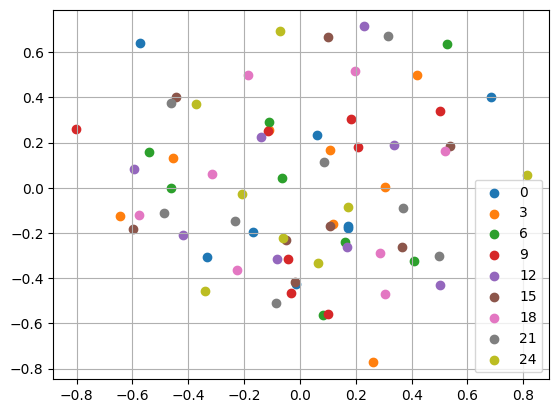

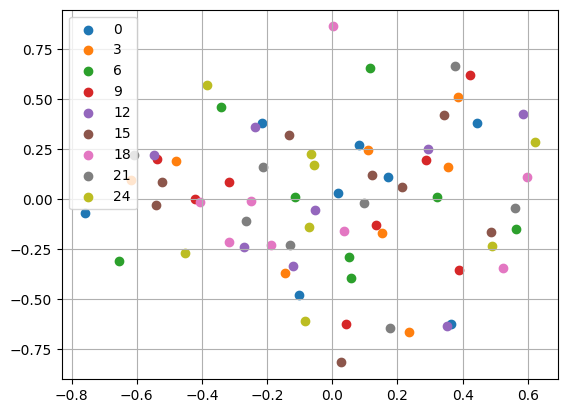

In [8]:
#torch.concat( (torch.stack((weights, weights)), weights.unsqueeze(-1).T))
#with torch.no_grad():
#    display(weights.unsqueeze(-1).T.shape)
fig, ax = plt.subplots()
for key in epoch_tracker:
    with torch.no_grad():
        U,S,V = torch.pca_lowrank(epoch_tracker[key], center=True, q=2)
        U=U.detach().cpu().numpy()
        ax.scatter(U.T[0], U.T[1], label=key)
ax.legend()
ax.grid(True)
plt.show()

fig2, ax2 = plt.subplots()
for key in last_weight:
    with torch.no_grad():
        U,S,V = torch.pca_lowrank(last_weight[key], center=True, q=2)
        U=U.detach().cpu().numpy()
        ax2.scatter(U.T[0], U.T[1], label=key)
ax2.legend()
ax2.grid(True)
plt.show()

array([<Axes: xlabel='epoch'>, <Axes: xlabel='epoch'>], dtype=object)

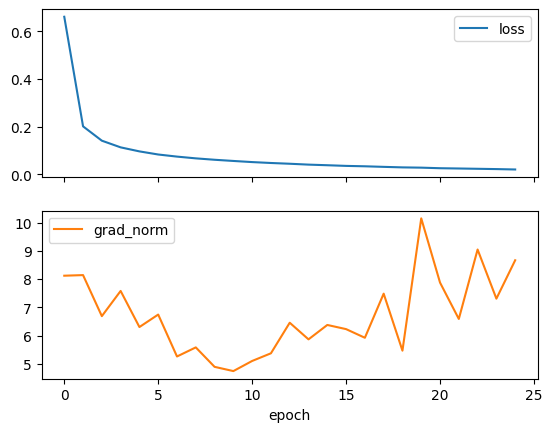

In [9]:
df.plot(x='epoch', y=['loss','grad_norm'], subplots=True)